In [ ]:
%pip install unidiff
%pip install seaborn

In [19]:
# AI based
# RAG Triads
# Grader 0-10 based on real changes (bouncer like)

import json
from unidiff import PatchSet
from collections import defaultdict

with open("./data/test.json", "r") as f:
    ground_truth = json.load(f)

overall_stats = {}

for issue_details in ground_truth:
    recommended_is_fetched = True
    with open(f"./data/v1/{issue_details['instance_id']}.json", "r") as f:
        generated_details = json.load(f)

    
    
    ground_truth_diff = issue_details["patch"]
    patch = PatchSet(ground_truth_diff)
    file_modifications = defaultdict(list)
    
    # percentage
    # fetches_modified_files
    # fetches modified snippets (contained)
    # recommended files are modified
    # recommended snippets are modified
    
    # v1 all fetched chunks
    all_fetched_chunks = generated_details["mayil_collected_data"]["relevant_snippets"]
    fetched_for_modifications = defaultdict(list)
    for chunk in all_fetched_chunks:
        fetched_file = chunk["filename"]
        fetched_for_modifications[fetched_file].append((chunk["start_line"], chunk["end_line"]))
    all_fetched_chunks = fetched_for_modifications

    if "snippet_processor_task" in generated_details["mayil_collected_data"]:
        recommended_is_fetched = False
        all_processed_chunks = generated_details["mayil_collected_data"]["snippet_processor_task"]
        fetched_for_modifications = defaultdict(list)
        for fetched_file, chunks in all_processed_chunks.items():
            for chunk in chunks:
                fetched_for_modifications[fetched_file].append((chunk["chunk"]["start_line"], chunk["chunk"]["end_line"]))
    # reversed_ordered_ranges = ordered_ranges[::-1]
                
    issue_counter = {
        "recommended_is_fetched": recommended_is_fetched,

        "total_modified_files": 0,
        "modified_file_not_fetched": 0,

        "total_recommended_files": len(all_processed_chunks),
        "total_recommended_files_modified": 0,

        "total_recommended_snippets": sum([len(chunks) for chunks in all_processed_chunks.values()]),
        "total_recommended_snippets_modified": 0,

        "total_fetched_snippets": sum([len(chunks) for chunks in all_fetched_chunks.values()]),
        "recommended_snippet_with_valid_range_removed": 0,
    }

    issue_counter["bouncer_score"] = generated_details["mayil_collected_data"]["bouncer_response"]["score"]
    
    for modified_file in patch.modified_files:
        issue_counter["total_modified_files"] += 1
        if modified_file.path in fetched_for_modifications:
            issue_counter["total_recommended_files_modified"] += 1
        else:
            if modified_file.path not in all_fetched_chunks:
                issue_counter["modified_file_not_fetched"] += 1

        useful_snippets = set()
        useful_snippets_removed = set()
        for change in modified_file:
            file_modifications[modified_file.path].append((change.source_start,str(change)))
            if modified_file.path in fetched_for_modifications:
                for fetched_chunk in fetched_for_modifications[modified_file.path]:
                    if fetched_chunk[0] <= change.source_start <= fetched_chunk[1]:
                        useful_snippets.add(fetched_chunk)
                        break
                # if matched:
                #     issue_counter["total_recommended_snippets_modified"] += 1
            else:
                if modified_file.path in all_fetched_chunks:
                    for fetched_chunk in all_fetched_chunks[modified_file.path]:
                        if fetched_chunk[0] <= change.source_start <= fetched_chunk[1]:
                            useful_snippets_removed.add(fetched_chunk)
                            break
        issue_counter["total_recommended_snippets_modified"] = len(useful_snippets)
        issue_counter["recommended_snippet_with_valid_range_removed"] = len(useful_snippets_removed)
    overall_stats[issue_details["instance_id"]] = issue_counter
    

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.DataFrame.from_dict(overall_stats, orient='index')
# get count of entries with recommended_is_fetched as True
print(df["recommended_is_fetched"].value_counts())
# drop the rows with recommended_is_fetched as True
df = df[df["recommended_is_fetched"] == False]
# drop the 2 cases where no modification but only additions 
df = df[df['total_modified_files']!=0]
# for issue_details in ground_truth:
#     if issue_details["instance_id"] in df[df['total_modified_files']==0].index:
#         print(issue_details["patch"])

recommended_is_fetched
False    2226
True       68
Name: count, dtype: int64


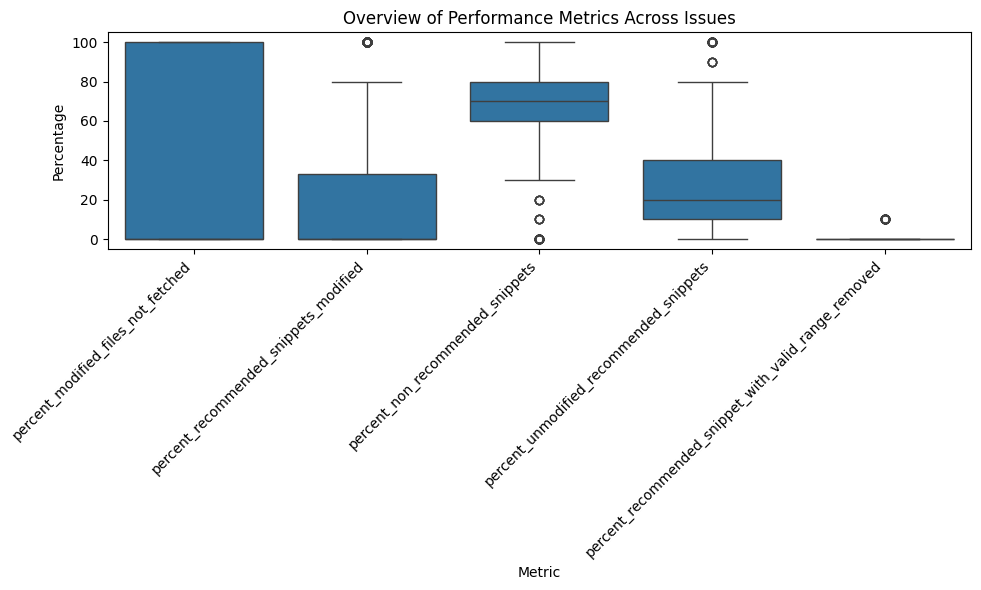

percent_modified_files_not_fetched                      35.488846
percent_recommended_snippets_modified                   17.321055
percent_non_recommended_snippets                        69.554856
percent_unmodified_recommended_snippets                 26.097122
percent_recommended_snippet_with_valid_range_removed     0.157374
dtype: float64

In [21]:
# Adding a new column to assess the performance of each issue
df['performance_score'] = np.where(
    df['total_recommended_snippets'] > 0,
    (df['total_recommended_snippets_modified'] / df['total_recommended_snippets']) * 100,
    0
) - np.where(
    df['total_modified_files'] > 0,
    (df['modified_file_not_fetched'] / df['total_modified_files']) * 100,
    0
)

min_score = df['performance_score'].min()
max_score = df['performance_score'].max()
df['rescaled_performance_score'] = (df['performance_score'] - min_score) / (max_score - min_score) * 100

df['unmodified_recommended_snippets'] = df['total_recommended_snippets'] - df['total_recommended_snippets_modified']
df['non_recommended_snippets'] = df['total_fetched_snippets'] - df['total_recommended_snippets'] - df['recommended_snippet_with_valid_range_removed']

df['percent_modified_files_not_fetched'] = (df['modified_file_not_fetched'] / df['total_modified_files']) * 100

df['percent_recommended_snippets_modified'] = (df['total_recommended_snippets_modified'] / df['total_recommended_snippets']) * 100

df['percent_non_recommended_snippets'] = (df['non_recommended_snippets'] / df['total_fetched_snippets']) * 100

df['percent_unmodified_recommended_snippets'] = (df['unmodified_recommended_snippets'] / df['total_fetched_snippets']) * 100

df['percent_recommended_snippet_with_valid_range_removed'] = (df['recommended_snippet_with_valid_range_removed'] / df['total_fetched_snippets']) * 100



# Dataframe for boxplot

percent_df = df[['percent_modified_files_not_fetched', 'percent_recommended_snippets_modified', 'percent_non_recommended_snippets', 'percent_unmodified_recommended_snippets', 'percent_recommended_snippet_with_valid_range_removed']]



# Melting the dataframe for seaborn boxplot

percent_df_melted = percent_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Percentage')



# Plotting

plt.figure(figsize=(10, 6))

sns.boxplot(x='Metric', y='Percentage', data=percent_df_melted)

plt.title('Overview of Performance Metrics Across Issues')

plt.xticks(rotation=45, ha='right')
# rotation=45, ha='right'

plt.tight_layout()

plt.show()



# Overview metrics across issues

overview_metrics = percent_df.mean()

overview_metrics

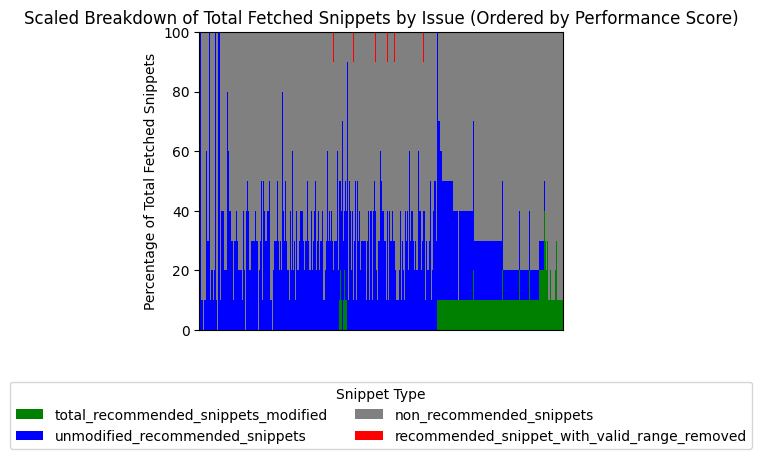

In [22]:
# Scaling and ordering the stacked chart based on performance score, then scaling to 100%

df_sorted = df.sort_values(by='rescaled_performance_score')

for col in ['total_recommended_snippets_modified', 'unmodified_recommended_snippets', 'non_recommended_snippets', 'recommended_snippet_with_valid_range_removed']:

    df_sorted[col] = (df_sorted[col] / df_sorted['total_fetched_snippets']) * 100



df_sorted[['total_recommended_snippets_modified', 'unmodified_recommended_snippets', 'non_recommended_snippets', 'recommended_snippet_with_valid_range_removed']].plot(kind='bar', width=1.0, stacked=True, color=['green', 'blue', 'grey', 'red'])

plt.title('Scaled Breakdown of Total Fetched Snippets by Issue (Ordered by Performance Score)')

plt.ylabel('Percentage of Total Fetched Snippets')

plt.ylim(0, 100)

plt.xticks([])

plt.legend(title='Snippet Type', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.tight_layout()

plt.show()

([<matplotlib.axis.XTick at 0x2c46cd000>,
 [Text(0.0, 0, '1'),
  Text(117.0, 0, '118'),
  Text(234.0, 0, '235'),
  Text(351.0, 0, '352'),
  Text(468.0, 0, '469'),
  Text(585.0, 0, '586'),
  Text(702.0, 0, '703'),
  Text(819.0, 0, '820'),
  Text(936.0, 0, '937'),
  Text(1053.0, 0, '1054'),
  Text(1170.0, 0, '1171'),
  Text(1287.0, 0, '1288'),
  Text(1404.0, 0, '1405'),
  Text(1521.0, 0, '1522'),
  Text(1638.0, 0, '1639'),
  Text(1755.0, 0, '1756'),
  Text(1872.0, 0, '1873'),
  Text(1989.0, 0, '1990'),
  Text(2106.0, 0, '2107'),
  Text(2223.0, 0, '2224')])

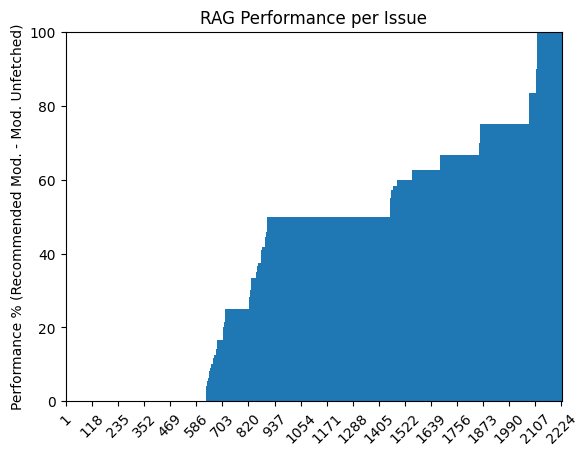

In [34]:
sorted_performance_large = df.sort_values("rescaled_performance_score")
sorted_performance_large['rescaled_performance_score'].plot(kind='bar', width=1.0)
# (sorted_performance_large['bouncer_score']*10).plot(color='red')
plt.title('RAG Performance per Issue')
plt.ylabel('Performance % (Recommended Mod. - Mod. Unfetched)')
plt.ylim(0, 100)
plt.xticks(np.linspace(0, len(sorted_performance_large) - 1, num=20), labels=[str(int(x)) for x in np.linspace(1, len(sorted_performance_large), num=20)], rotation=45)

([<matplotlib.axis.XTick at 0x2c99aaec0>,
 [Text(0.0, 0, '1'),
  Text(117.0, 0, '118'),
  Text(234.0, 0, '235'),
  Text(351.0, 0, '352'),
  Text(468.0, 0, '469'),
  Text(585.0, 0, '586'),
  Text(702.0, 0, '703'),
  Text(819.0, 0, '820'),
  Text(936.0, 0, '937'),
  Text(1053.0, 0, '1054'),
  Text(1170.0, 0, '1171'),
  Text(1287.0, 0, '1288'),
  Text(1404.0, 0, '1405'),
  Text(1521.0, 0, '1522'),
  Text(1638.0, 0, '1639'),
  Text(1755.0, 0, '1756'),
  Text(1872.0, 0, '1873'),
  Text(1989.0, 0, '1990'),
  Text(2106.0, 0, '2107'),
  Text(2223.0, 0, '2224')])

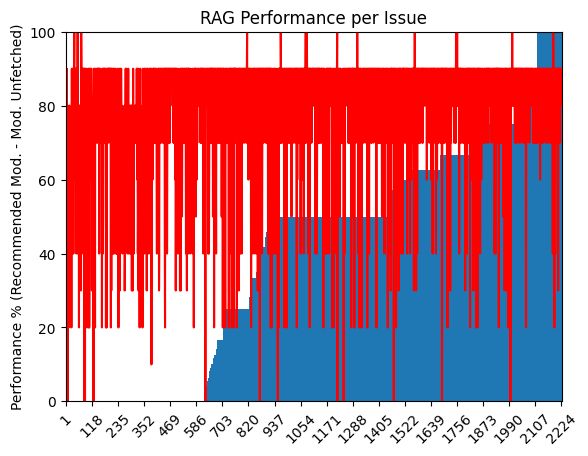

In [35]:
sorted_performance_large = df.sort_values("rescaled_performance_score")
sorted_performance_large['rescaled_performance_score'].plot(kind='bar', width=1.0)
(sorted_performance_large['bouncer_score']*10).plot(color='red')
plt.title('RAG Performance per Issue')
plt.ylabel('Performance % (Recommended Mod. - Mod. Unfetched)')
plt.ylim(0, 100)
plt.xticks(np.linspace(0, len(sorted_performance_large) - 1, num=20), labels=[str(int(x)) for x in np.linspace(1, len(sorted_performance_large), num=20)], rotation=45)

In [36]:
# get counts of issues with performance score in different ranges 0, 1-20, 21-40, 41-60, 61-80, 81-99, 100
counts = {}
ranges = [(0, 0), (1, 20), (21, 40), (41, 60), (61, 80), (81, 99), (100, 100)]
for i in range(len(ranges)):
    counts[i] = df[(df['rescaled_performance_score'] >= ranges[i][0]) & (df['rescaled_performance_score'] <= ranges[i][1])].shape[0]
for i in range(len(ranges)):
    print(f"{ranges[i]}: {counts[i]}")

(0, 0): 627
(1, 20): 84
(21, 40): 167
(41, 60): 674
(61, 80): 525
(81, 99): 35
(100, 100): 112
